# Introduction
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/food-processing/main.ipynb)._]

## Business Problem
This notebook focuses on making resolving the issue of inventory management by performing a sales/demand prediction on a quantile basis and hence giving the business an opportunity to choose how aggressive or reserved they want to be with the inventory acquisition and hence the manufacturing capabilities.

For manufacturing industries, when it comes to sales both the extreme scenarios are unfavorable:

* When there is an unexpectedly **high demand** - *it will cause stock-outs*
* When there is unexpectedly **low demand** - *it will cause dead inventory*


## The solution: making quantile predictions, and letting the business choose

So the solution is to predict the whole spectrum of sales numbers and hence adjusting the inventory or the stocks as per the business risk appetite and keeping the future demand roughly **“as expected”.**

The normal mean or median based methods tend to ignore the extreme situations and derive towards the "usual" scenario. Hence, mostly these methods are not very effective at preventing both stock-outs and dead inventory. Quantile forecasts approach the challenge head-on and directly look at the scenario of interest, say avoiding stock-outs, and strive to provide a precise answer to this very problem. 

### Advantages of using the quantiles based sales prediction

* **Dead Inventory Reduction** - One of the major sources of revenue leakage for manufacturing industries is dead inventory i.e. raw materials that were bought but were never used. The storage of such raw materials is also a cost so they cannot be stored forever. 

* **Prioritizing supply chain decisions** - The demand forecasts can be used to drive supply chain decisions such as making purchase orders for commerce or triggering a production batch in an industrial setting.

* **Injecting the supply chain constraints** -  There are often constraints by the suppliers for minimum order either at the SKU level or at the order level and they can be tweaked as per the business desire based on the forecast.

## Dataset used:
The dataset used is synthesized data for a salad company. 
It contains 4 main data sources namely:

* saladcontents - containing information about the salad products, their ingredients, and the quantity
* price - information about the production cost and selling price of each product
* ingredients - for each ingredient, how much refrigeration volume it takes, and the price
* sales - historical sales data for each product; this data will be used to make a *quantile based sales prediction*.

In [1]:
# These are some dependencies that must be installed to run this notebook properly.
# !pip install mxnet
# !pip install gluonts
# !pip install s3fs

In [2]:
# Import MXNET
import mxnet as mx
from mxnet import gluon

# Import other python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

# Importing from GluonTS
# from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas

import atoti as tt

# Part 1- The basics: Loading data and cube creation

## Load ingredients, contents, price and sales data

In [3]:
# creating a session - it spins up an in-memory database - similar to Apache Spark - ready to slice’n’dice your big data set.
# In addition to that, it launches a dashboarding Tableau-like web-app
session = tt.Session(user_content_storage="content")

In [4]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

In [5]:
# loading salad content here, load the csv file directly into the store

salad_content = session.read_csv(
    "s3://data.atoti.io/notebooks/agro/salad_content.csv",
    keys=["prod_id", "ing_id"],
    table_name="salad_content",
)
salad_content.head()

product_name  quantity
prod_id       ing_id                                     
561_GCS_salad 53534         Greek Chicken Salad      12.5
              56764         Greek Chicken Salad      10.0
              735           Greek Chicken Salad      75.0
558_CS_salad  3735                 Caesar Salad      17.5
572_CPS_salad 53534   Chicken Pesto Pasta Salad      25.0

In [6]:
# loading prices datasets, load the file with pandas, make the changes as required and then load the pandas df in the atoti store

price_df = pd.read_csv("https://data.atoti.io/notebooks/agro/selling_price.csv")
price = session.read_pandas(
    price_df.drop("product_name", axis=1),
    keys=["prod_id"],
    table_name="price",
)
price.head()

,production_cost,selling_price
prod_id,,
561_GCS_salad,2.1,32.50
558_CS_salad,1.5,28.75
761_TCS_salad,1.9,31.25
641_CCS_salad,2.3,37.00
583_GVS_salad,1.5,27.50


In [7]:
# loading ingredients datasets, load the csv file directly into the store

ingredients = session.read_csv(
    "s3://data.atoti.io/notebooks/agro/ingredients.csv",
    keys=["ing_id"],
    table_name="ingredients",
    types={"volume_occupied": tt.type.DOUBLE},
)
ingredients.head()

,ingredient,volume_occupied,cost
ing_id,,,
53534,lettuce,0.63,0.023
34534,parmesan,0.54,0.080
976,feta,0.48,0.070
845,pasta,0.62,0.035
56764,sweet_corn,0.05,0.045


#### The sales data

For the sales data, we shall add an additional column as predicted sales. This column will have nan values for the training period(when we have the actual sales numbers) and will contain the predictions for all the quantiles.
While the sales column will have the sales number for the training period will contain nan for the prediction window.

In [8]:
# loading the sales data into an atoti store

# laoading the sales datframe and adding a column for the predictions

sales_df = pd.read_csv("https://data.atoti.io/notebooks/agro/sales.csv")

# Initialize a variable as an empty list first of lengh of size of the dataframe.
x = [None] * len(sales_df["prod_id"])
sales_df["predicted_sales"] = np.array(x)

# convert date column to date
sales_df["date"] = pd.to_datetime(sales_df["date"])


# crete the store
sales = session.read_pandas(
    sales_df.drop("product_name", axis=1),
    keys=["prod_id", "date"],
    table_name="sales",
    types={
        "predicted_sales": tt.type.DOUBLE_ARRAY,
        "sales": tt.type.DOUBLE,
    },
)
sales.head()

sales predicted_sales
prod_id       date                             
561_GCS_salad 2019-01-01   80.0            None
              2019-01-05   75.0            None
              2019-01-08   85.0            None
              2019-01-29   89.0            None
              2019-02-08  126.0            None

In [9]:
# Now we join the newly created stores to the salad content store

salad_content.join(price, mapping={"prod_id": "prod_id"})

salad_content.join(ingredients, mapping={"ing_id": "ing_id"})

salad_content.join(sales, mapping={"prod_id": "prod_id"})

## Creating the cube

In [10]:
cube = session.create_cube(salad_content, "SaladCube")

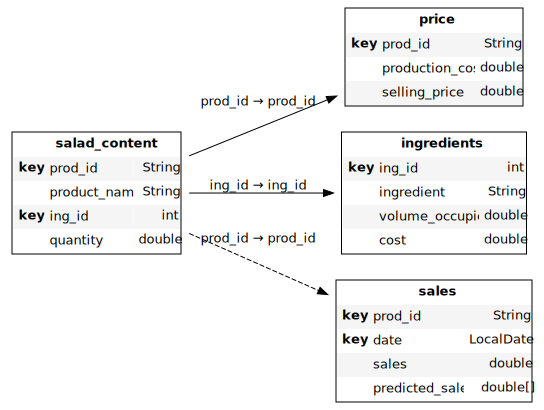

In [11]:
cube.schema

In [12]:
# defining the newmy created measure, level and hierarchy
m = cube.measures
lvl = cube.levels
h = cube.hierarchies

# *PART 2:* The sales predictions

The sales predictions are made for each product, for a set of quantiles and this is appended to the sales store created above.


In order to do time series forecast, *the dataset* is reshaped with dates as rows and each product as a column, as shown below:

In [13]:
# defining te dataframe
df = sales_df.pivot(index="date", columns="product_name", values="sales")

In [14]:
df.reset_index(level=0, inplace=True)

In [15]:
for column in df.columns:
    print(column)

date
Caesar Salad
Cheese Chicken Salad
Chicken Pesto Pasta Salad
Greek Chicken Salad
Grilled Veggies Salad
Turkish Chickpea Salad


In [16]:
# to make the column names consistent, we change all column name to lower case and add an underscore

column_names = []
for column in df.columns:
    column = re.sub("\s+", "", column)
    column = re.sub(r"(?<!^)(?=[A-Z])", "_", column).lower()
    column_names.append(column)
df.columns = column_names

In [17]:
df.head()

,date,caesar_salad,cheese_chicken_salad,chicken_pesto_pasta_salad,greek_chicken_salad,grilled_veggies_salad,turkish_chickpea_salad
0,2019-01-01,30,32,13,80,101,65
1,2019-01-02,47,53,98,105,148,97
2,2019-01-03,51,53,39,101,124,86
3,2019-01-04,66,71,103,122,161,113
4,2019-01-05,25,27,6,75,95,59


## The model used for making predictions

[GluonTS](https://gluon-ts.mxnet.io/index.html) is a python toolkit for probabilistic time series modeling, built around [Apache MXNet (incubating)](https://mxnet.incubator.apache.org/versions/1.7.0/). It has been built by the [Amazon Web Services - Labs](https://github.com/awslabs). 

GlounTS leverages the truly open source **deep learning framework** suited for flexible research prototyping and production at Apache MXNet.

Here we will do a time series based forecasting for the sales using the prior sales data.  We will use GluonTS for making the probabilistic forecasts and then the values corresponding to a mist of given quantiles are picked from the forecast. 

#### Model accuracy:

On splitting the total data into 80:20 train: test, the model gave an **R2 value of 0.85 and Mean absolute error of 5.46**.
However, the whole of the dataset is used for the training while making the final predictions.

### Training the neural network for each  product

In [18]:
mx.random.seed(36)
np.random.seed(36)

for column in df.columns[1:]:

    training_data = ListDataset([{"start": df.date[0], "target": df[column]}], freq="D")

    # We only use three epoch to make this run faster.
    # In real life application, you would use more epochs for an improved accuracy

    estimator = DeepAREstimator(
        freq="D", prediction_length=60, trainer=Trainer(epochs=3)
    )
    predictor = estimator.train(training_data=training_data)

    test_data = ListDataset([{"start": df.date[0], "target": df[column]}], freq="D")

    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        pass

    globals()["sales_" + str(df[column].name)] = []
    print(df[column].name)

    for i in np.linspace(0, 0.99, 100):
        globals()["sales_" + str(df[column].name)].append(forecast.quantile(i))

    globals()["sales_" + str(df[column].name)] = np.reshape(
        globals()["sales_" + str(df[column].name)], (100, 60)
    ).T

    globals()["sales_" + str(df[column].name)] = globals()[
        "sales_" + str(df[column].name)
    ].tolist()

    print(type(globals()["sales_" + str(df[column].name)]))

    for i, item in enumerate(globals()["sales_" + str(df[column].name)]):

        new = [int(round(j)) for j in item]
        new2 = [i if i > 0 else 0 for i in new]
        (globals()["sales_" + str(df[column].name)])[i] = new2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.29it/s, epoch=3/3, avg_epoch_loss=2.88]


caesar_salad
<class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.63it/s, epoch=3/3, avg_epoch_loss=3.18]


cheese_chicken_salad
<class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.84it/s, epoch=3/3, avg_epoch_loss=4.87]


chicken_pesto_pasta_salad
<class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.91it/s, epoch=3/3, avg_epoch_loss=3.52]


greek_chicken_salad
<class 'list'>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.63it/s, epoch=3/3, avg_epoch_loss=4.3]


grilled_veggies_salad
<class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.75it/s, epoch=3/3, avg_epoch_loss=3.85]


turkish_chickpea_salad
<class 'list'>


In [19]:
# create a new dataframe to be appended

col_names = list(sales_df.columns)
df_to_append = pd.DataFrame(columns=col_names)

In [20]:
df_to_append = df_to_append.drop("product_name", axis=1)

In [21]:
# defining the range of dates and the list of products
list_products = [
    "561_GCS_salad",
    "558_CS_salad",
    "761_TCS_salad",
    "641_CCS_salad",
    "583_GVS_salad",
    "572_CPS_salad",
]
list_date = pd.date_range(
    start=df.loc[df.index[-1], "date"], periods=61, freq="D", inclusive="right"
)

In [22]:
# loading the dates and changing the format to datetime
df_to_append["date"] = list_date
df_to_append["date"] = pd.to_datetime(df_to_append["date"])

# replicate the dates for each product
df_to_append = pd.concat([df_to_append] * len(list_products), ignore_index=True)

In [23]:
# defining the list of product ids to fit in the dataframe
product_id = []
for prod in list_products:
    product_append = np.repeat(prod, len(list_date))
    product_id.append(product_append)

# flattening the product_id list
list_product_id = []
for x in product_id:
    for y in x:
        list_product_id.append(y)

In [24]:
# concatenating  the list of various predictions for each product
predicted_sales = (
    sales_greek_chicken_salad
    + sales_caesar_salad
    + sales_turkish_chickpea_salad
    + sales_cheese_chicken_salad
    + sales_grilled_veggies_salad
    + sales_chicken_pesto_pasta_salad
)

In [25]:
# appending values in the dataframe

df_to_append["prod_id"] = list_product_id
df_to_append["sales"] = np.nan
df_to_append["predicted_sales"] = predicted_sales

In [26]:
df_to_append.head()

,prod_id,date,sales,predicted_sales
0,561_GCS_salad,2019-11-01,NaN,"[102, 109, 111, 112, 113, 113, 113, 114, 116, ..."
1,561_GCS_salad,2019-11-02,NaN,"[69, 74, 75, 82, 84, 86, 86, 86, 87, 87, 89, 8..."
2,561_GCS_salad,2019-11-03,NaN,"[46, 62, 74, 74, 76, 80, 81, 82, 82, 82, 83, 8..."
3,561_GCS_salad,2019-11-04,NaN,"[75, 76, 77, 78, 80, 81, 82, 83, 83, 84, 84, 8..."
4,561_GCS_salad,2019-11-05,NaN,"[81, 82, 83, 86, 86, 87, 87, 87, 87, 88, 88, 8..."


Here it is interesting to note that with [atoti](https://www.atoti.io/), we can load an entire vector as a column in the data frame.
Which in turn saved us from saved the creation of a plethora of rows and columns pertinent to each quartile.

### appending this df to the sales store in atoti

In [27]:
sales.load_pandas(df_to_append)

In [28]:
sales.head(5000)

sales  \
prod_id       date                
561_GCS_salad 2019-01-01   80.0   
              2019-01-05   75.0   
              2019-01-08   85.0   
              2019-01-29   89.0   
              2019-02-08  126.0   
...                         ...   
583_GVS_salad 2019-11-15    NaN   
              2019-11-24    NaN   
572_CPS_salad 2019-11-18    NaN   
              2019-11-23    NaN   
              2019-12-15    NaN   

                                                            predicted_sales  
prod_id       date                                                           
561_GCS_salad 2019-01-01                                               None  
              2019-01-05                                               None  
              2019-01-08                                               None  
              2019-01-29                                               None  
              2019-02-08                                               None  
...                                                                     ...  
583_GVS_salad 2019-11-15  [84.0, 92.0, 95.0, 102.0, 106.0, 107.0, 112.0,...  
              2019-11-24  [68.0, 69.0, 76.0, 76.0, 76.0, 78.0, 80.0, 80....  
572_CPS_salad 2019-11-18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
              2019-11-23  [0.0, 9.0, 10.0, 23.0, 28.0, 34.0, 35.0, 38.0,...  
              2019-12-15  [0.0, 0.0, 4.0, 14.0, 23.0, 23.0, 24.0, 25.0, ...  

[2184 rows x 2 columns]

### Interesting to note:

Thanks to the capability of atoti to support vectors, we can store and use the entire prediction quintiles in one column which would have been 100 different columns in pandas.

# Part 3: The atoti magic

Here the power of data cubes with atoti is leveraged to perform cube slicing and scenario creation for the additional storage capacity, associated cost incurred, etc.

Since most of the sales information is on a date level, let us create a slicing by date

In [29]:
h["date"].slicing = True

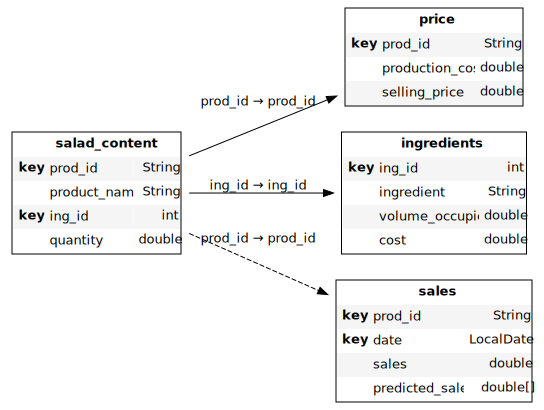

In [30]:
cube.schema

In [31]:
qtle = cube.create_parameter_simulation(name="qtle", measures={"quantile": 0.5})

In [32]:
# we define the various measures associated with cost and sales on product and ingredient level
m["sales.VALUE"] = tt.agg.single_value(sales["sales"])
m["predicted_sales.VALUE"] = tt.agg.single_value(sales["predicted_sales"])

# m["quantile"] = 0.50
m["quantile_total_predicted_sales"] = tt.array.quantile(
    m["predicted_sales.VALUE"], m["quantile"]
)

m["consolidated_sales.SUM"] = tt.agg.sum(
    tt.where(
        m["sales.VALUE"].isnull(), m["quantile_total_predicted_sales"], m["sales.VALUE"]
    ),
    scope=tt.OriginScope(lvl["date"]),
)

### Plotting the daily sales(including the predictions) for all the products

In [33]:
session.visualize("Actual & predicted sales for the whole year")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Here the sales prediction is for the 50th quantile of the prediction spectrum.

Later in this section, we will create scenarios and try to predict the sales using the extreme prediction scenarios (99th or 1st quantile of sales predictions)

### New information inflow:

Presuming we now can access the storage capacity, we create a database with the storage capacity.

Adding a store for the storage capacity of each product(in Litres) and joining this store to the original cube.

In [34]:
storage_data = {
    "prod_id": [
        "561_GCS_salad",
        "558_CS_salad",
        "761_TCS_salad",
        "641_CCS_salad",
        "583_GVS_salad",
        "572_CPS_salad",
    ],
    "storage_capacity": [20000, 18000, 18200, 14000, 22500, 21000],
}

# we now store the above information in a dataframe
product_storage_df = pd.DataFrame(storage_data, columns=["prod_id", "storage_capacity"])

In [35]:
# create a store from the newly created dataframe

product_storage = session.read_pandas(
    product_storage_df,
    keys=["prod_id"],
    table_name="product_storage",
    types={"storage_capacity": tt.type.DOUBLE},
)

In [36]:
# joinig the storage store to the salad content store on product ID
salad_content.join(product_storage, mapping={"prod_id": "prod_id"})

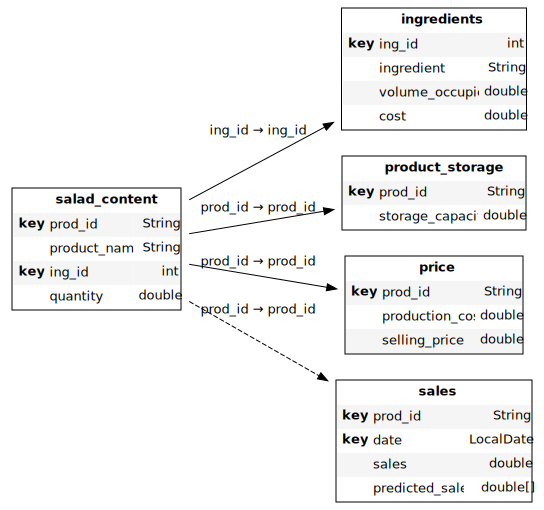

In [37]:
cube.schema

Here, it is interesting to highlight the flexibility of atoti to add a new store and  hence leveraging any additional information that flows in once the cube is created.

In [38]:
m["volume_occupied.VALUE"] = tt.agg.single_value(ingredients["volume_occupied"])
m["storage_capacity.VALUE"] = tt.agg.single_value(product_storage["storage_capacity"])
# defining the measure for the volume occupied by each salad product

m["product_volume"] = tt.agg.sum_product(
    m["volume_occupied.VALUE"],
    m["quantity.SUM"],
    scope=tt.OriginScope(lvl["prod_id"], lvl["ing_id"]),
)

# creating a measure for the refrigeration storage available
m["storage_capacity"] = tt.agg.sum(
    m["storage_capacity.VALUE"], scope=tt.OriginScope(lvl["prod_id"], lvl["date"])
)

# creating a measure for the refrigeration storage available
m["storage_used"] = tt.agg.sum(
    (m["product_volume"]) * m["consolidated_sales.SUM"],
    scope=tt.OriginScope(lvl["prod_id"], lvl["date"]),
)

In [39]:
# creating a measure for the additional storage required
m["available_storage"] = m["storage_capacity"] - m["storage_used"]

### **atoti chart**

Visualizing the additional space required for the various products ( Can also be filtered by each product).

Here the sales prediction is for the 50th quantile of the prediction spectrum.

Negative available storage implies that the storage has been all used up and we need to acquire some additional storage.

So, for the 50th percentile of sales prediction, there seems to be no requirement for additional storage space. 

In [40]:
session.visualize("Available storage for 0.50 quantile")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Scenario creation

With atoti, we can create scenarios for the quantile of interest and hence compare the various scenarios.

In [41]:
qtle += ("0.99", 0.99)
qtle += ("0.01", 0.01)
qtle += ("0.50", 0.50)

### Available storage
Let us filter 3 salad products: Greek Chicken Salad, Caesar Salad and Turkish Chickpea Salad for the **99th and 1st quantile of prediction.**

We can see below that the **Ceaser Salad does not require any additional storage space even for the 99th quqntile of sales volume**  

In [42]:
session.visualize("Available storage")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

# Interpretation of these numbers

Here the focus of our analysis will be on the additional revenue/cost for the additional product i.e. the 99th quantile scenario.

### There are two approaches to interpret these volumes:

### 1. Excess products 
In terms of excess products for each product id and each quantile

In [43]:
m["excess_products"] = tt.agg.sum(
    tt.where(
        m["available_storage"] < 0,
        tt.math.ceil(-m["available_storage"] / m["product_volume"]),
        0,
    ),
    scope=tt.OriginScope(lvl["prod_id"]),
)

In [44]:
session.visualize("excess products for all quantiles")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [45]:
session.visualize("excess products for all quantiles")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Here it is interesting to note that for the 0.01 and the 0.5 quantiles, the excess products are always zero as they can be stored in the available storage already existing

### 1.1 Insight:
Potential additional revenue when there we have no restriction on storage capacity.

In [46]:
m["selling_price.VALUE"] = tt.agg.single_value(price["selling_price"])
# we simply mutilpy the excess products with the selling price of each to find the potential revenue if there are no extra refrigerators

m["potential_additional_revenue"] = tt.agg.sum(
    m["excess_products"] * m["selling_price.VALUE"],
    scope=tt.OriginScope(lvl["prod_id"]),
)

In [47]:
session.visualize("potential additional revenue")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Now let us have a look at the Total Potential additional revenue - Breakdown  per product.

In [48]:
m["total_potential_additional_revenue"] = tt.agg.sum(
    m["potential_additional_revenue"], scope=tt.SiblingsScope(hierarchy=h["date"])
)

In [49]:
session.visualize("product-wise total potential additional revenue")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2. The number of additional refrigerators.

Another interesting way to interpret the volumes is by seeing how many many refrigerators are required to store the products.

One standard kitchen size refrigerator has a storage capacity of approx **200 Litres**.

In [50]:
# defining a measure for refrigerator volume
m["volume_refrigerator"] = 200

# creating a measure for the cost of additional refrigerators
# This is done by taking the minimum volume between the number of products that can be stored and the number of excess products
m["additional_refrigerator_required"] = tt.agg.sum(
    tt.where(
        m["available_storage"] < 0,
        tt.math.ceil(-m["available_storage"] / m["volume_refrigerator"]),
        0,
    ),
    scope=tt.OriginScope(lvl["prod_id"]),
)

Here we can convert the volume required into the number of refrigerators.

In [51]:
session.visualize("additional refrigerators required")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Again, for the 0.5 and 0.01 quantiles of sales, we do not need any additional refrigerators, as all the products can be stored in the existing storage.

### 2.1 Insight:

We define the measure of additional refrigerators available.

Let us assume that the cost per refrigerator per day is **5 Euros.**

In [52]:
# Creating a simulation for number of refrigerator, with 5 as default.

number_additional_refrigerator = cube.create_parameter_simulation(
    name="additional_refrigerator",
    measures={"number_additional_refrigerator": 5},
)

In [53]:
# defining a measure for the additional refrigerators being equipped for the prediction period

m["additional_refrigerator_equipped"] = tt.agg.sum(
    tt.where(
        lvl["date"] > datetime.date(2019, 11, 1), m["number_additional_refrigerator"], 0
    ),
    scope=tt.OriginScope(lvl["date"]),
)

We also create scenarios with varying number of refrigerators equipped.

In [54]:
number_additional_refrigerator += ("10", 10)
number_additional_refrigerator += ("15", 15)
number_additional_refrigerator += ("20", 20)
number_additional_refrigerator += ("25", 25)
number_additional_refrigerator += ("40", 40)

### How much revenue do we still miss out if we acquire "some" refrigerators?

In [55]:
m["storable_products"] = tt.math.min(
    tt.agg.sum(
        m["additional_refrigerator_equipped"]
        * m["volume_refrigerator"]
        / m["product_volume"],
        scope=tt.OriginScope(lvl["prod_id"]),
    ),
    m["excess_products"],
)

m["potential_additional_realized_revenue"] = tt.agg.sum(
    m["storable_products"] * m["selling_price.VALUE"],
    scope=tt.OriginScope(lvl["prod_id"]),
)

In [56]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [57]:
session.visualize("potential revenue missed for different number of refrigerator")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that the potential revenue which could be realized is directly proportional to the refrigerators being equipped.

So we can keep on increasing the number of refrigerators to tap on all the potential revenue.

But then the refrigerators have their own costs as well.

### Calculate the cost incurred in various scenarios

In [58]:
m["cost.VALUE"] = tt.agg.single_value(ingredients["cost"])
m["production_cost.VALUE"] = tt.agg.single_value(price["production_cost"])
m["total_ingredient_cost"] = tt.agg.sum(
    m["cost.VALUE"] * m["quantity.SUM"], scope=tt.OriginScope(lvl["ing_id"])
)


m["cost_ingredient"] = tt.agg.sum(
    m["total_ingredient_cost"] * m["storable_products"],
    scope=tt.OriginScope(lvl["prod_id"]),
)

# We know that the daily cost per refrigerator is 5 euros, so creating a measure for that

m["daily_cost_refrigerator"] = 5
m["cost_additional_storage"] = (
    m["additional_refrigerator_equipped"] * m["daily_cost_refrigerator"]
)

# set scope as `prod_id` as it is the key of the price store.
m["production_cost_total"] = tt.agg.sum(
    m["production_cost.VALUE"] * m["storable_products"],
    scope=tt.OriginScope(lvl["prod_id"]),
)

# defining the cost of salad
m["total_additional_cost"] = (m["cost_ingredient"] + m["cost_additional_storage"]) + m[
    "production_cost_total"
]

### Pivot table to compare daily addtional potential margin and additional costs in various scenarios

In [59]:
m["total_additional_cost.SUM"] = tt.agg.sum(
    m["total_additional_cost"], scope=tt.SiblingsScope(hierarchy=h["date"])
)
m["potential_additional_realized_revenue.SUM"] = tt.agg.sum(
    m["potential_additional_realized_revenue"],
    scope=tt.SiblingsScope(hierarchy=h["date"]),
)

The total cost incurred in various scenarios

In [60]:
session.visualize(
    "total cost for production of salad - operating cost + additional storage"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [61]:
session.visualize("daily potential additional revenue and potential additional cost")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Comparing the additional cost and the additional realized revenue in various scenarious with the refrigerators 

Hence in the various scenarios, the potential revenue which will be realized increases but so does the cost incurred with an increasing number of refrigerators.

In order to find the optimum number of refrigerators, we need to calculate the margin for each of the scenarios, thanks to the power of OLAP cube, it can be done with **just one line of code**.

### Defining the margin for the various additional refrigerators

In [62]:
m["margin"] = (
    m["potential_additional_realized_revenue.SUM"] - m["total_additional_cost.SUM"]
)

In [63]:
session.visualize("net margin for all the scenarios")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that the margin is maximum for 15 refrigerators and it keeps on decreasing after that as the operating cost increases and there is a cap on the maximum additional revenue to be realized.

## Visualizing the info in a dashboard 

The various scenarious and simulations can be simultaneously compared using a dashbard in atoti. 
These dashoboards are highly customisable and can be designed using the various widgets as per the business objective.
These can be saved and shared silpky by sharing a URL.
Click on the link below to explore a sample dashboard we created!!

In [64]:
session.link(path="#/dashboard/fd7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Conclusion:

Hence in this notebook, we calculated various sales prediction scenarios and hence calculated the available storage and the surplus products required in each of the scenarios.

In the case with the high sales predictions- the 0.99 quantile, we calculated the additional refrigerator required and also the maximum potential additional revenue which could be realized.

Finally, atoti enabled us to choose the aggressiveness of our strategy with regards to the number of refrigerators we want to  and in order to maximize the margin at the same time, giving us the opportunity to slice and dice the numbers on a daily basis on a scenario basis or even on the basis of the additional cost and the additional potential revenue.

For more interesting notebooks, check out the [atoti gallary](https://github.com/atoti/notebooks)

# _ _The end_ _